# Mapping human fetal thymus Visium sections with fetal reference

## Contents
* [Loading packages](#Loading_packages)
* [Loading Visium and single cell data data](#Loading_Visium)
1. [Estimating cell type signatures (NB regression)](#Estimating_signatures)
2. [Cell2location: spatial mapping](#cell2location)
3. [Visualising cell abundance in spatial coordinates](#Visualising)
4. [Downstream analysis](#downstream)
* [Leiden clustering of cell abundance](#region_clustering)
* [Identifying cellular compartments / tissue zones using matrix factorisation (NMF)](#NMF)
5. [Advanced use](#advanced)
* [Estimate cell-type specific expression of every gene in the spatial data](#per_cell_type_expression)
* [Working with the posterior distribution and computing arbitrary quantiles](#posterior_summary)

## Loading packages <a class="anchor" id="Loading_packages"></a>

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
from datetime import date
today = str(date.today())
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'pdf')

sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-04-19 08:08.


In [4]:
import os
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/Figure2'

First, let's define where we save the results of our analysis:

In [5]:
results_folder = '/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v9_fetal_sub_15K'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading scRNA-seq reference data <a class="anchor" id="Loading_Visium"></a>

In [18]:
adata_ref_all = sc.read("/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/Thymus_Atlas_v16_postQC.h5ad")

In [19]:
adata_ref_all.X = adata_ref_all.layers['counts']
del adata_ref_all.layers['counts']

# clean object 

In [20]:
adata_ref = adata_ref_all[adata_ref_all.obs['age_group'] == 'fetal', :].copy() # subset to fetal 
del adata_ref_all
adata_ref

AnnData object with n_obs × n_vars = 157859 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 

In [21]:
adata_ref = adata_ref[:,~adata_ref.var['cite']] # remove cite genes
adata_ref


View of AnnData object with n_obs × n_vars = 157859 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_sp

In [22]:
adata_ref.obs['study'].value_counts()

Park2020        101911
Bautista2021     55948
Name: study, dtype: int64

In [23]:
adata_ref.obs['annotation_level_3'].value_counts().keys()

CategoricalIndex(['T_DP(P)', 'T_DP(Q)', 'EC-Cap', 'PeriloFb', 'T_αβT(entry)',
                  'T_DN(CD4)', 'EC-Ven', 'EC-Art', 'T_CD4', 'T_DN(P)',
                  'T_DP(Q)-HSPH1', 'T_DP(Q)-early', 'InterloFb', 'T_DN(Q)',
                  'cTECI', 'Pericyte', 'SMC', 'T_SP-HSP', 'T_CD8',
                  'T_reg(agonist)', 'T_CD8αα(I)', 'T_DN(Q)-early',
                  'T_CD8-Prolif', 'mcTEC', 'mcTEC-Prolif', 'RBC', 'medFb',
                  'T_DP(Q)-CD99', 'T_DN(early)', 'EC-Cap-Prolif',
                  'InterloFb-COL9A3', 'mTECI', 'T_reg', 'PeriloFb-Prolif',
                  'T_DN(Q)-CD99', 'T_DN(CD4)-CD99', 'EC-IFI44L', 'T_NK',
                  'T_γδT', 'EC-Ven-VCAN', 'Mural', 'DC1', 'TEC-myo', 'VSMC',
                  'Pericyte_COL1A1', 'T_CD8αα(II)', 'Pericyte_CCL19',
                  'T_reg(diff)-FOXP3hi', 'ProlifPericyte', 'mTECI-trans',
                  'TEC-neuro', 'T_CD8αα(entry)', 'EC-Lympatic',
                  'medFb-PDGFRAlo', 'cTECII', 'B-pro/pre', 'medFb-R

In [24]:
# remove cells for fetal 
to_remove = ['T_SP-HSP','T_DP(Q)-HSPH1','cTECIII','Fb-SBSPON','Mesothelium','Mural',
             'Pericyte_CCL19','ProlifPericyte','B-stimulated','DC-Prolif','TEC-tuft',
             'medFb-PDGFRAlo','T_DN(Q)-CD99','T_DN(CD4)-CD99','T_DP(Q)-early','plasma-cells']
adata_ref = adata_ref[~adata_ref.obs['annotation_level_3'].isin(to_remove),:].copy()
adata_ref

AnnData object with n_obs × n_vars = 142145 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 

In [25]:
# downsample source 
target_cells = 5000
target_cells_subclass = 1000
cluster_key = 'annotation_level_3'
adatas = [adata_ref[adata_ref.obs[cluster_key].isin([clust])] for clust in list(adata_ref.obs[cluster_key].cat.categories)]

for dat in adatas:
    if dat.n_obs > target_cells_subclass:
        if np.unique(dat.obs['annotation_level_3'].isin(['PeriloFb', 'EC-Ven', 'EC-Cap', 'EC-Art', 'InterloFb','Pericyte', 'SMC', 'medFb']))[0]:
            sc.pp.subsample(dat, n_obs=target_cells_subclass)
        else:
            if dat.n_obs > target_cells:
                sc.pp.subsample(dat, n_obs=target_cells)

adata_ref = adatas[0].concatenate(*adatas[1:])
adata_ref.obs['annotation_level_3'].value_counts()

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


T_DP(Q)                5000
T_αβT(entry)           5000
T_DP(P)                5000
T_DN(CD4)              5000
T_CD4                  4893
T_DN(P)                4046
T_DN(Q)                3615
cTECI                  3396
T_CD8                  3086
T_reg(agonist)         2696
T_CD8αα(I)             2488
T_DN(Q)-early          2121
T_CD8-Prolif           1726
mcTEC                  1611
mcTEC-Prolif           1573
RBC                    1503
T_DP(Q)-CD99           1428
T_DN(early)            1266
EC-Cap-Prolif          1179
InterloFb-COL9A3       1128
mTECI                  1059
T_reg                  1045
medFb                  1000
EC-Art                 1000
SMC                    1000
Pericyte               1000
EC-Cap                 1000
EC-Ven                 1000
PeriloFb               1000
InterloFb              1000
PeriloFb-Prolif         983
EC-IFI44L               853
T_NK                    768
T_γδT                   749
EC-Ven-VCAN             656
DC1                 

In [26]:
adata_ref

AnnData object with n_obs × n_vars = 81189 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', '

## Highly variable gene selection

In [27]:
adata_ref = adata_ref.copy()


# remove vdj genes
import re
adata_ref.var['vdj'] = False
for i in adata_ref.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i):
        adata_ref.var.at[i, 'vdj'] = True
adata_ref = adata_ref[:,~adata_ref.var['vdj']]
adata_ref


cc_genes =  ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']

def remove_selected_genes(adata,lst,remove_also_mt=True):
    for g in lst:
        adata = adata[:,~(adata.var_names==g)]
    if remove_also_mt:
        adata = adata[:,~(adata.var_names.str.startswith('MT-'))]
    return adata

adata_ref = remove_selected_genes(adata_ref,cc_genes,remove_also_mt=True)  

sc.pp.highly_variable_genes(
        adata_ref,
        n_top_genes=15000,
        subset=True,
        # layer='counts',
        flavor="seurat_v3",
        batch_key="annotation_level_3",
        span=1,
    )


View of AnnData object with n_obs × n_vars = 81189 × 36005
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spl

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [55]:
# from cell2location.utils.filtering import filter_genes

In [16]:
# selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.12)

In [17]:
# adata_ref = adata_ref[:, selected].copy()
# adata_ref

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimating_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [28]:
adata_ref.shape

(81189, 15000)

In [29]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key='annotation_level_3', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['chemistry_simple','study','donor'],
                        continuous_covariate_keys=['age_numeric'],
                       )

In [30]:
# create and train the regressiolayersdel
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 
# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'annotation_level_3',
│   'categorical_covariate_keys': ['chemistry_simple', 'study', 'donor'],
│   'continuous_covariate_keys': ['age_numeric']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  33   │
│         n_cells          │ 81189 │
│ n_extra_categorical_covs │   3   │
│ n_extra_continuous_covs  │   1   │
│         n_labels         │  67   │
│          n_vars          │ 15000 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  F83_TH_EPCAM  │          0          │
│                     │ FCAImmP7179369 │          1          │
│                     │ FCAImmP7179370 │          2          │
│                     │ FCAImmP7198634 │          3          │
│                     │ FCAImmP7198635 │          4          │
│                     │ FCAImmP7277556 │          5          │
│                     │ FCAImmP7277557 │          6          │
│                     │ FCAImmP7277564 │          7          │
│                     │ FCAImmP7277565 │          8          │
│                     │ FCAImmP7292030 │          9          │
│                     │ FCAImmP7292034 │         10          │
│                     │ FCAImmP7528283 │         11          │
│                     │ FCAImmP7528284 │         12          │
│                     │ FCAImmP7528285 │         13          │
│                     │ FCAImmP7528294 │         14          │
│                     │ FCAImmP7555851 │         15          │
│                     │ FCAImmP7555852 │         16          │
│                     │ FCAImmP7555860 │         17          │
│                     │ FCAImmP7555861 │         18          │
│                     │ FCAImmP7579218 │         19          │
│                     │ FCAImmP7579219 │         20          │
│                     │ FCAImmP7579230 │         21          │
│                     │ FCAImmP7579231 │         22          │
│                     │ FCAImmP7851890 │         23          │
│                     │ FCAImmP7851891 │         24          │
│                     │ FCAImmP7851892 │         25          │
│                     │ FCAImmP7851893 │         26          │
│                     │ FCAImmP7851894 │         27          │
│                     │ FCAImmP7851895 │         28          │
│                     │ FCAImmP7851896 │         29          │
│                     │   GSM4466780   │         30          │
│                     │   GSM4466781   │         31          │
│                     │   GSM4466782   │         32          │
└─────────────────────┴────────────────┴─────────────────────┘

                             labels State Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location         ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['annotation_level_3'] │        B(P)         │          0          │
│                                 │        B(Q)         │          1          │
│                                 │      B-pro/pre      │          2          │
│                                 │        DC-a1        │          3          │
│                                 │        DC-a3        │          4          │
│                                 │         DC1         │          5          │
│                                 │         DC2         │          6          │
│                                 │       EC-Art        │          7          │
│                                 │       EC-Cap        │          8          │
│                                 │    EC-Cap-Prolif    │          9          │
│                                 │      EC-IFI44L      │         10          │
│                                 │     EC-Lympatic     │         11          │
│                                 │       EC-Ven        │         12          │
│                                 │     EC-Ven-VCAN     │         13          │
│                                 │         ETP         │         14          │
│                                 │      InterloFb      │         15          │
│                                 │  InterloFb-COL9A3   │         16          │
│                                 │  Macrophage-CD163   │         17          │
│                                 │   Macrophage-CD68   │         18          │
│                                 │        Mast         │         19          │
│                                 │      Monocyte       │         20          │
│                                 │     Neutrophil      │         21          │
│                                 │      Pericyte       │         22          │
│                                 │   Pericyte_COL1A1   │         23          │
│                                 │      PeriloFb       │         24          │
│                                 │   PeriloFb-Prolif   │         25          │
│                                 │         RBC         │         26          │
│                                 │         SMC         │         27          │
│                                 │       Schwann       │         28          │
│                                 │    TEC-cilliated    │         29          │
│                                 │       TEC-myo       │         30          │
│                                 │      TEC-neuro      │         31          │
│                                 │        T_CD4        │         32          │
│                                 │        T_CD8        │         33          │
│                                 │    T_CD8-Prolif     │         34          │
│                                 │     T_CD8αα(I)      │         35          │
│                                 │     T_CD8αα(II)     │         36          │
│                                 │   T_CD8αα(entry)    │         37          │
│                                 │      T_DN(CD4)      │         38          │
│                                 │       T_DN(P)       │         39          │
│                                 │       T_DN(Q)       │         40          │
│                                 │    T_DN(Q)-early    │         41          │
│                                 │     T_DN(early)     │         42          │
│                                 │       T_DP(P)       │         43          │
│                                 │       T_DP(Q)       │         44          │
│                                 │    T_DP(Q)-CD99     │         45          │


                extra_categorical_covs State Registry                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['chemistry_simple'] │     3GEX     │          0          │
│                               │     5GEX     │          1          │
│                               │              │                     │
│      adata.obs['donor']       │     F21      │          0          │
│                               │     F23      │          1          │
│                               │     F29      │          2          │
│                               │     F30      │          3          │
│                               │     F38      │          4          │
│                               │     F41      │          5          │
│                               │     F45      │          6          │
│                               │     F64      │          7          │
│                               │     F67      │          8          │
│                               │     F83      │          9          │
│                               │    baut1     │         10          │
│                               │    baut2     │         11          │
│                               │    baut3     │         12          │
│                               │              │                     │
│      adata.obs['study']       │ Bautista2021 │          0          │
│                               │   Park2020   │          1          │
│                               │              │                     │
└───────────────────────────────┴──────────────┴─────────────────────┘

extra_continuous_covs State 
          Registry          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['age_numeric'] │
└──────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/250:   0%| | 1/250 [00:05<21:54,  5.28s/it, v_num=1, elbo_train=3.49e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 250/250: 100%|█| 250/250 [24:12<00:00,  9.27s/it, v_num=1, elbo_train=2.12

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|█| 250/250 [24:12<00:00,  5.81s/it, v_num=1, elbo_train=2.12


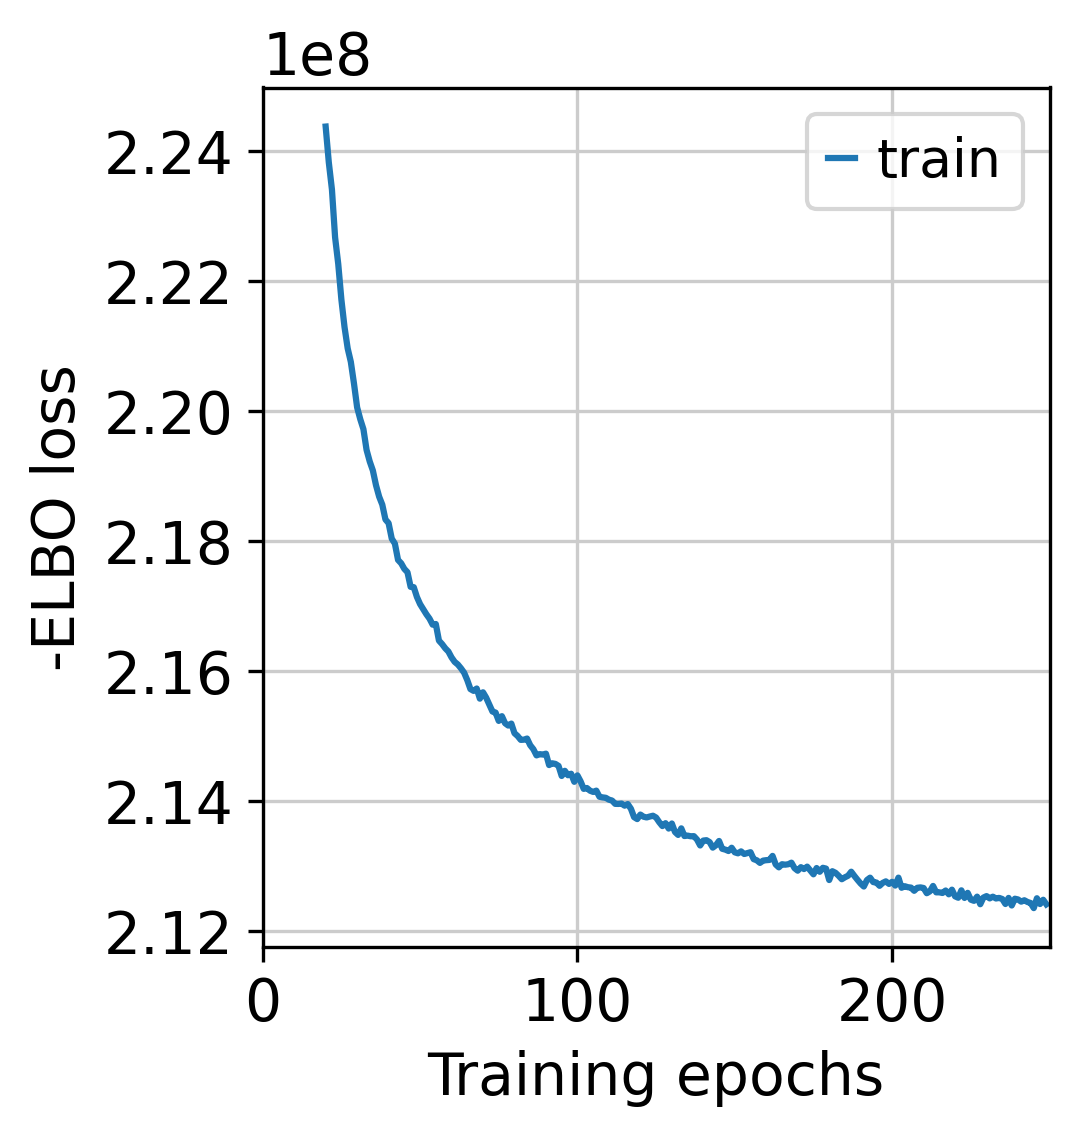

In [31]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [32]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

Sampling global variables, sample: 100%|██████| 999/999 [00:48<00:00, 20.76it/s]


In [33]:
# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v9_fetal_sub_15K/reference_signatures/sc.h5ad'

In [34]:
# load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 81189 × 15000
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', '

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

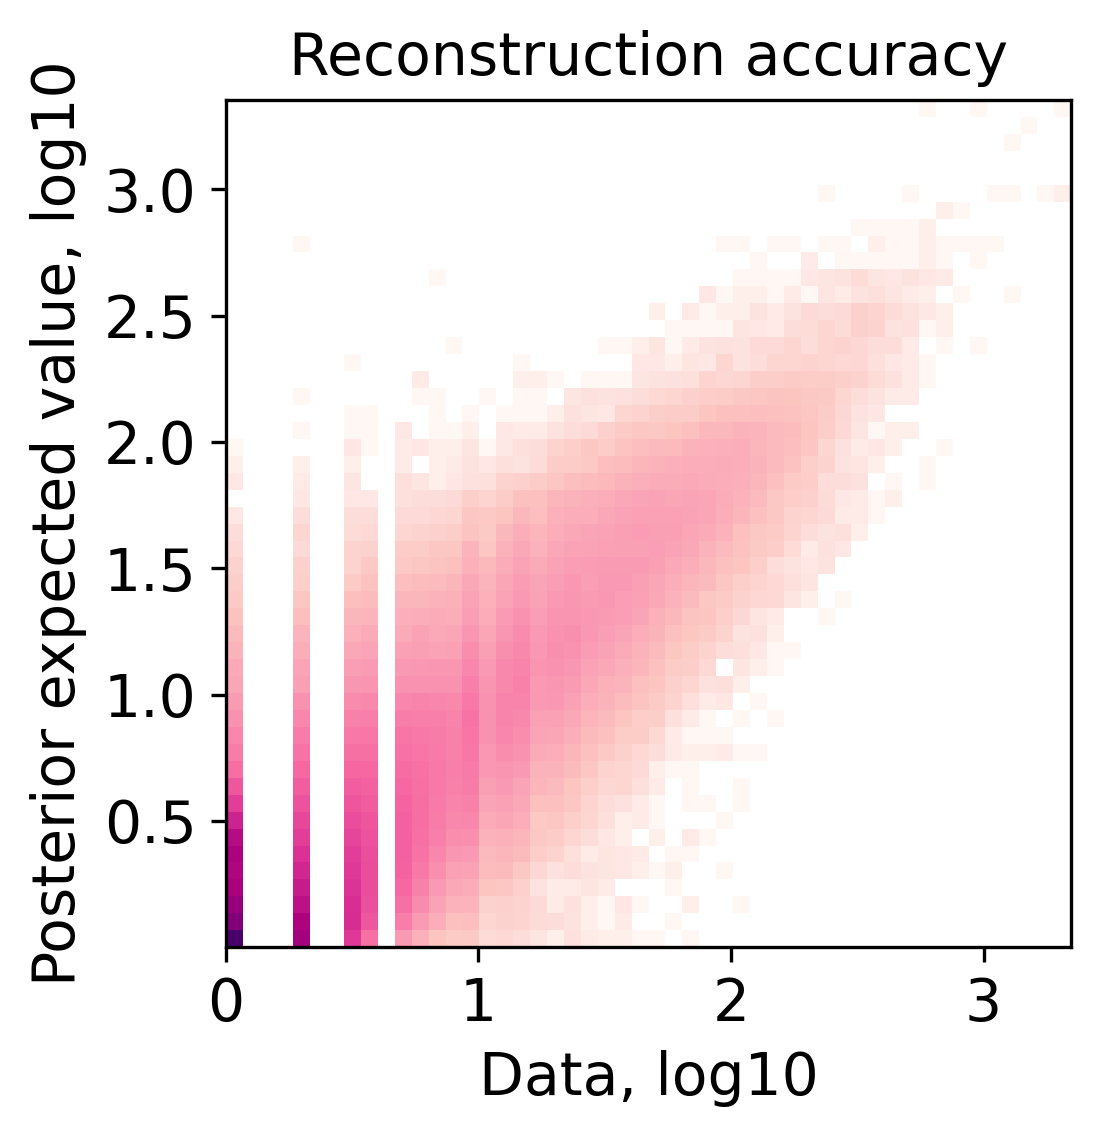

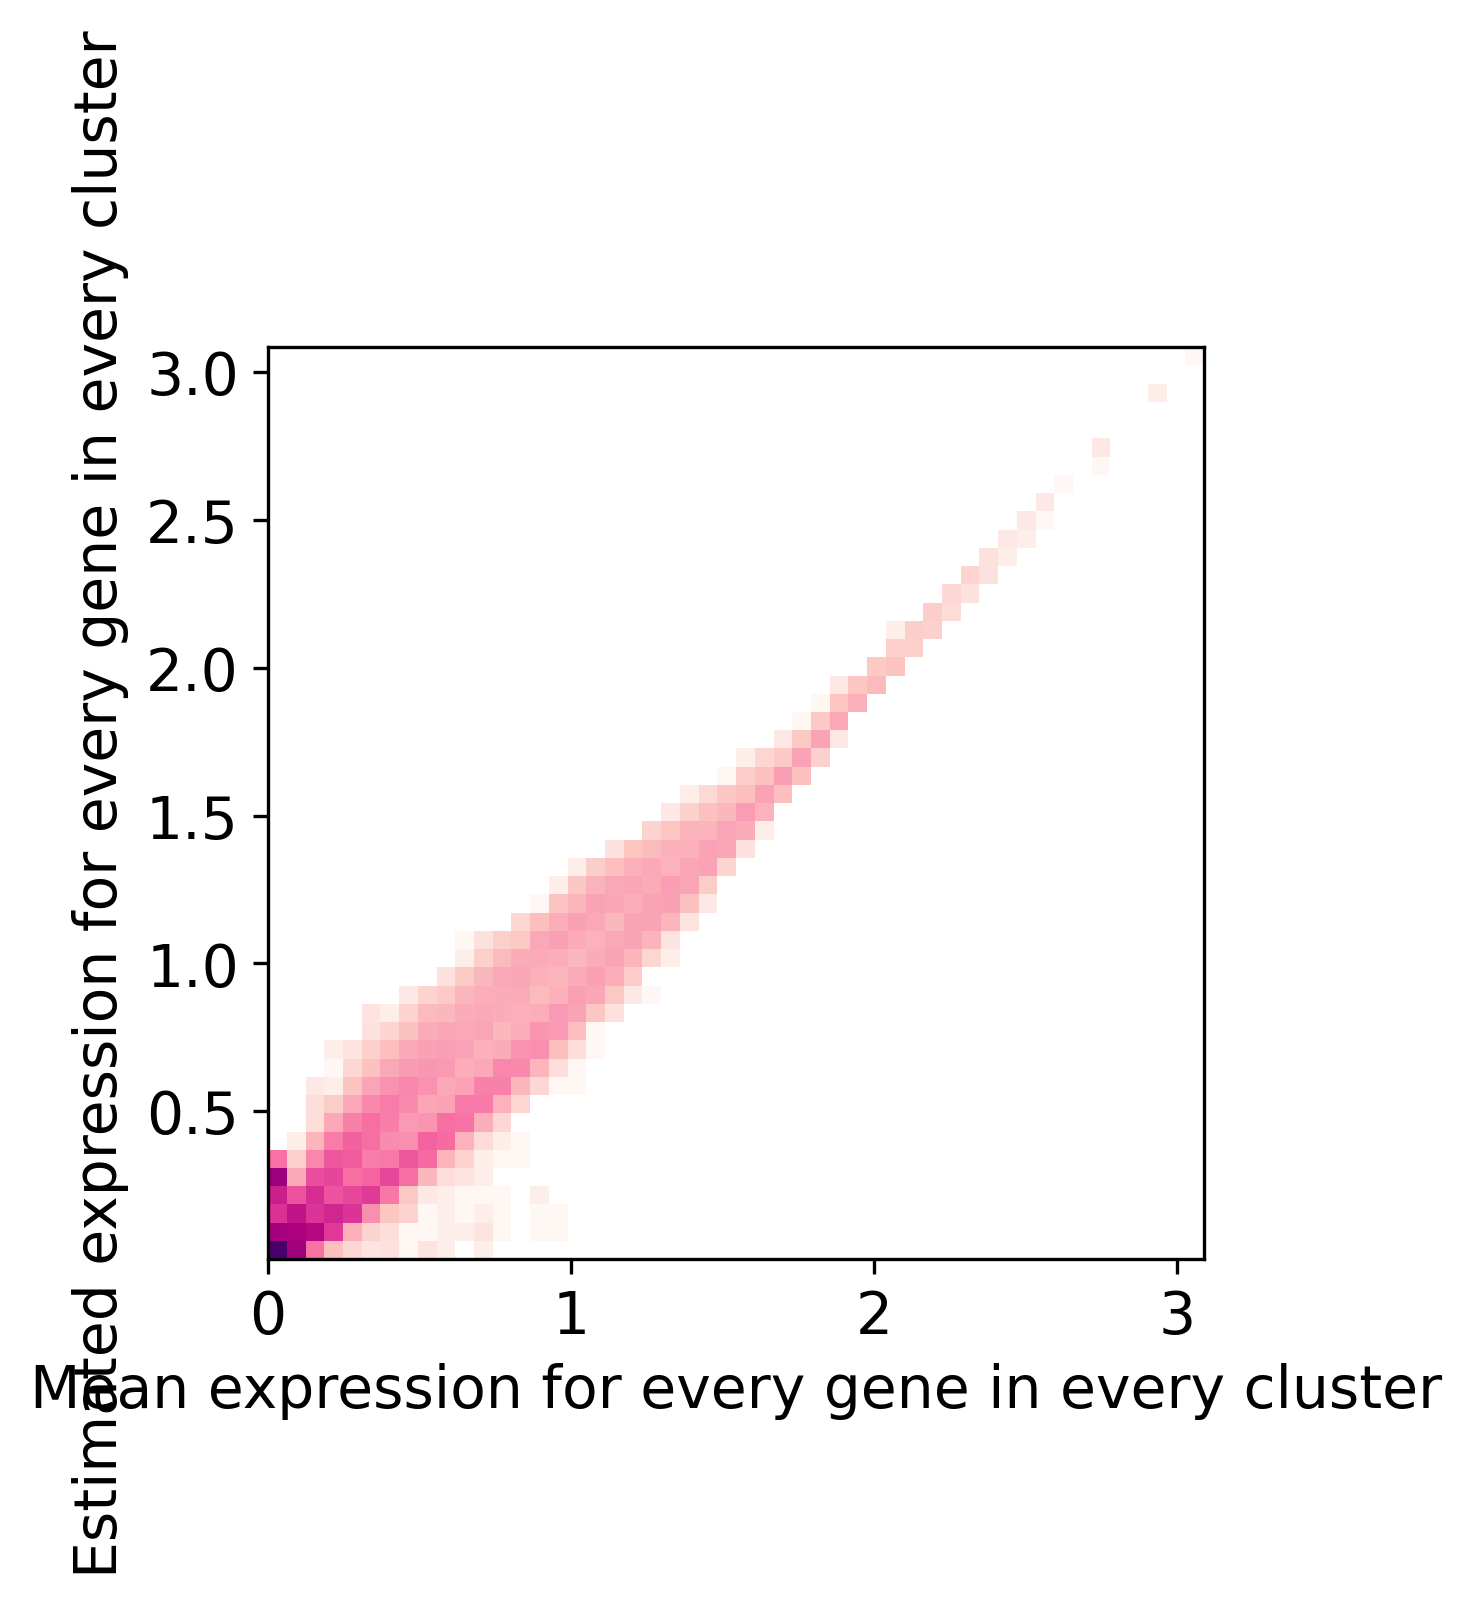

In [23]:
mod.plot_QC()

#read in results of regression model (if notebook is reloaded)
adata_ref = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/reference_signatures/sc.h5ad")
adata_vis = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/adata_vis_2021-10-01.h5ad")

In [35]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B(P),B(Q),B-pro/pre,DC-a1,DC-a3
AL627309.5,0.005345,0.005066,0.002045,0.012322,0.007653
LINC01409,0.052324,0.008156,0.010463,0.017855,0.016523
LINC00115,0.013884,0.008240,0.003598,0.012027,0.011200
FAM41C,0.004975,0.003997,0.004127,0.019125,0.004364
AL645608.2,0.104035,0.116610,0.014223,0.332862,0.100625


## Cell2location: spatial mapping <a class="anchor" id="cell2location"></a>

In [36]:
#The model and output h5ad can be loaded later like this:

adata_vis_all = sc.read("/nfs/team205/vk8/projects/thymus_atlas/results/Thymus_atlas_v2_Visium_raw_2022-09-07.h5ad")

In [37]:
adata_vis = adata_vis_all[adata_vis_all.obs['Age_group'] == 'fetal'].copy()

In [38]:
for i in adata_vis.uns['spatial'].keys():
    del adata_vis.uns['spatial'][i]['images']['hires']
    del adata_vis.uns['spatial'][i]['images']['hires5K']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires5K_scalef']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires_scalef']

In [39]:
adata_vis.uns['spatial']['spaceranger122_count_34880_WSSS_THYst9142086_GRCh38-2020-A']['scalefactors'].keys()

dict_keys(['fiducial_diameter_fullres', 'spot_diameter_fullres', 'tissue_lowres_scalef'])

adata_file = f"{ref_run_name}/sp.h5ad"
adata_ref = sc.read('/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_all/reference_signatures/sc.h5ad')

#mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [40]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()

In [41]:
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 17408 × 36588
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'L2_dist_Annotation_lv_0_Artifacts', 'Annotation_lv_0', 'L2_dist_Annotation_lv_0_Background', 'L2_dist_Annotation_lv_0_Cortex', 'L2_dist_Annotation_lv_0_Edge', 'L2_dist_Annotation_lv_0_Medulla', 'L2_dist_log10_Annotation_lv_1_HS', 'Annotation_lv_1', 'L2_dist_log10_Annotation_lv_1_Lymph', 'L2_dist_log10_Annotation_lv_1_PVS', 'L2_dist_log10_Annotation_lv_1_Unassigned', 'Annotation_lobules', 'Cortico_Medullar_Axis', 'SampleID', 'L2_dist_Annotation_lv_0_Unassigned', 'Annotation_lobules_0', 'Annotation_lobules_1', 'L2_dist_log10_Annotation_lv_1_Fat', 'Leiden_0_5', 'L2_dist_log10_Annotation_lv_1_Large vessel', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min

In [42]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
#adata_vis = adata_vis[~adata_vis.obs['SampleID'].isin(['S000001583_U11FO2_D1_st9142089',\
#                                                     'V11J11-100_Z1-THY-FO2_A1_TA11486161',\
                                                 #   'V19D02-039_U09-THY-FO1a_C1_st9518032', \
#                                                    ]), intersect].copy()
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [43]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="SampleID",
                                                categorical_covariate_keys=['SlideID','Spaceranger','section_thickness (um)'],continuous_covariate_keys=['Age(numeric)','n_genes_by_counts'])

Here you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).

<div class="alert alert-block alert-danger">
<b>Note!</b>
While you can often use the default value of `detection_alpha` hyperparameter, it is useful to  <b>adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.
</div>

In [44]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=35,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 

mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'SampleID',
│   'labels_key': None,
│   'categorical_covariate_keys': ['SlideID', 'Spaceranger', 'section_thickness (um)'],
│   'continuous_covariate_keys': ['Age(numeric)', 'n_genes_by_counts']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  12   │
│         n_cells          │ 17408 │
│ n_extra_categorical_covs │   3   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 15000 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['SampleID'] │ WSSS_F_IMMsp9838711  │          0          │
│                       │ WSSS_F_IMMsp9838716  │          1          │
│                       │ WSSS_F_IMMsp10864183 │          2          │
│                       │ WSSS_F_IMMsp11604685 │          3          │
│                       │ WSSS_F_IMMsp11604686 │          4          │
│                       │ WSSS_F_IMMsp11604687 │          5          │
│                       │ WSSS_F_IMMsp11604688 │          6          │
│                       │ WSSS_F_IMMsp11604689 │          7          │
│                       │ WSSS_F_IMMsp11604690 │          8          │
│                       │ WSSS_F_IMMsp11765867 │          9          │
│                       │ WSSS_F_IMMsp11765868 │         10          │
│                       │ WSSS_F_IMMsp11765870 │         11          │
└───────────────────────┴──────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                  extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃           Source Location           ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│        adata.obs['SlideID']         │ V10U24-023 │          0          │
│                                     │ V10U29-029 │          1          │
│                                     │ V10U29-030 │          2          │
│                                     │ V10U29-031 │          3          │
│                                     │ V11M15-307 │          4          │
│                                     │ V11M15-308 │          5          │
│                                     │            │                     │
│      adata.obs['Spaceranger']       │   1.3.0    │          0          │
│                                     │            │                     │
│ adata.obs['section_thickness (um)'] │    15.0    │          0          │
│                                     │            │                     │
└─────────────────────────────────────┴────────────┴─────────────────────┘

   extra_continuous_covs State    
             Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   adata.obs['Age(numeric)']    │
│ adata.obs['n_genes_by_counts'] │
└────────────────────────────────┘

In [45]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2/30000:   0%| | 1/30000 [00:00<3:10:45,  2.62it/s, v_num=1, elbo_train=1.

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 997/30000:   3%| | 997/30000 [07:40<3:40:30,  2.19it/s, v_num=1, elbo_trai

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 5902/30000:  20%|▏| 5902/30000 [45:17<3:13:00,  2.08it/s, v_num=1, elbo_tr

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 10523/30000:  35%|▎| 10523/30000 [1:20:45<2:16:56,  2.37it/s, v_num=1, elb

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 15346/30000:  51%|▌| 15346/30000 [1:57:42<1:59:27,  2.04it/s, v_num=1, elb

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 20131/30000:  67%|▋| 20131/30000 [2:34:23<1:18:08,  2.10it/s, v_num=1, elb

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 24642/30000:  82%|▊| 24641/30000 [3:09:09<43:27,  2.06it/s, v_num=1, elbo_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 29319/30000:  98%|▉| 29318/30000 [3:45:14<05:16,  2.15it/s, v_num=1, elbo_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [46]:
run_name

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v9_fetal_sub_15K/cell2location_map'

In [47]:
# Save model and visium data 
adata_file = f"{run_name}/adata_vis.h5ad"
os.mkdir(run_name)
adata_vis.write(adata_file)
mod.save(f"{run_name}", overwrite=True)


# its best to restart the kernel at this point and load everything again to prevent GPU crashing

In [6]:

# load model and visium data 
adata_vis = sc.read_h5ad(f"{run_name}/adata_vis.h5ad")
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File /nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v9_fetal_su
         b_15K/cell2location_map/model.pt already downloaded                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%| | 1/30000 [00:00<1:22:17,  6.08it/s, v_num=1, elbo_train=1.

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%| | 1/30000 [00:00<1:24:50,  5.89it/s, v_num=1, elbo_train=1.


In [7]:
# load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B(P),B(Q),B-pro/pre,DC-a1,DC-a3
AL627309.5,0.005345,0.005066,0.002045,0.012322,0.007653
LINC01409,0.052324,0.008156,0.010463,0.017855,0.016523
LINC00115,0.013884,0.008240,0.003598,0.012027,0.011200
FAM41C,0.004975,0.003997,0.004127,0.019125,0.004364
AL645608.2,0.104035,0.116610,0.014223,0.332862,0.100625


In [8]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

Sampling global variables, sample: 100%|██████| 999/999 [00:25<00:00, 38.63it/s]


In [9]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v9_fetal_sub_15K/cell2location_map/sp.h5ad'